<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/VGG16_with_generated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG-16 For Detecting Pneumonia From X-Ray Images

In [1]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
# , load_img, img_to_array
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model, Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# listing the files in the directory
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/'

chest_xray  __MACOSX  normal_gan_added_to_train


In [4]:
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train/'
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train/'

test  train  val


## Data Preperation

In [5]:
# importing necessary packages
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# assigning variables with the proper file path for the training, validation and test set
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [7]:
# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

In [8]:
# image generator(Keras object) generates batches of tensor image data and this is the format that 
# the images nedd to be in and read by Keras model
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           zoom_range=0.3, vertical_flip=True) # Generator for training data
val_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data
test_image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# defining the hyperparameters
batch_size = 32
epochs = 20
img_height = 128
img_width = 128

In [10]:
# flow from directory is taking the path to a directory and generates batches of normalized data
# distribution of the datasets
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, directory=train_dir,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary', shuffle=True)
val_data_gen = val_image_generator.flow_from_directory(batch_size=2, directory=val_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',shuffle=True)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size, directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary', shuffle=True)

Found 7906 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Build Fine-Tuned VGG16 Model

In [ ]:
vgg16_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_height,img_width, 3))

In [12]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [13]:
# iterating over all the layers in VGG16 by creating a for loop
for i,layer in enumerate(vgg16_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [14]:
x = vgg16_model.output
x = Flatten()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation = "sigmoid")(x)

model = Model(input = vgg16_model.input, output = preds)

for layer in model.layers[:18]:
    layer.trainable=False
    
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


## Train the Fine-Tuned VGG model

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# number of images for both train and test sets
total_train = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
total_test = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))
print(total_train, total_test)

7906 624


In [17]:
%cd /content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train/

/content/drive/My Drive/Colab Notebooks/chest_xray/normal_gan_added_to_train


In [18]:
# fitting the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/vgg16_withgan_weights.hdf5', 
                             monitor='val_loss', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto',verbose=1)

history = model.fit_generator( 
    train_data_gen,
    steps_per_epoch = total_train // batch_size, epochs=epochs,
    validation_data=test_data_gen,
    validation_steps = total_test // batch_size,
    callbacks = [early_stopping, lr_reduce, checkpoint])

Epoch 1/20
247/247 [==============================] - 2325s 9s/step - loss: 0.4004 - accuracy: 0.8244 - val_loss: 0.3598 - val_accuracy: 0.8799
Epoch 2/20
247/247 [==============================] - 120s 488ms/step - loss: 0.2060 - accuracy: 0.9190 - val_loss: 0.2457 - val_accuracy: 0.8311
Epoch 3/20
247/247 [==============================] - 122s 495ms/step - loss: 0.2167 - accuracy: 0.9205 - val_loss: 0.3738 - val_accuracy: 0.8699
Epoch 4/20
247/247 [==============================] - 123s 498ms/step - loss: 0.1850 - accuracy: 0.9282 - val_loss: 0.2512 - val_accuracy: 0.8767

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
247/247 [==============================] - 123s 497ms/step - loss: 0.1474 - accuracy: 0.9469 - val_loss: 0.3003 - val_accuracy: 0.8986
Epoch 6/20
247/247 [==============================] - 123s 498ms/step - loss: 0.1338 - accuracy: 0.9522 - val_loss: 0.2771 - val_accuracy: 0.8784

Epoch 00006: ReduceLROnPlateau reducing lear

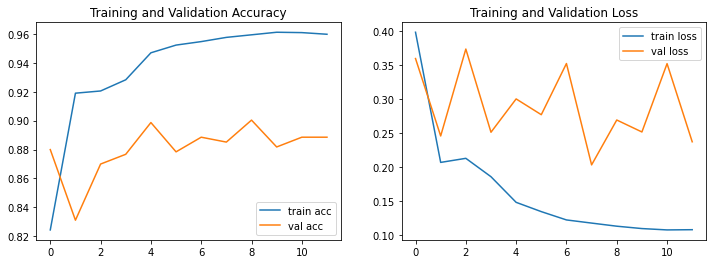

In [19]:
# plotting model accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(test_data_gen, steps=16)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.890625
Test loss: 0.3124958574771881


In [27]:
# Test your model on unknown samples (testing data)
val_loss, val_acc = model.evaluate_generator(val_data_gen, steps=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

Validation accuracy: 0.75
Validation loss: 0.18598559498786926


In [22]:
# saving model in H5 format.
model.save('/content/drive/My Drive/Colab Notebooks/vgg16_withgan_pneumonia.h5')

In [23]:
import cv2
import numpy as np
from collections import Counter

data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

# making predictions off of the test set 
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(data_path + 'test' + cond)):
        img = plt.imread(data_path +'test'+ cond + img)
        img = cv2.resize(img, (img_height, img_width))
        img = np.dstack([img, img, img]) #concatenates along the third dimension
        img = img.astype('float32') / 255
        if cond =='/NORMAL/':
            label = 0
        elif cond =='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", Counter(test_labels))

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: Counter({1: 390, 0: 234})


In [24]:
import seaborn as sns
# creating a function that plots the confusion matrix
def conf_matrix(conf_mat):
    labels = ['NORMAL', 'PNEUMONIA']
    ax=sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels,
                   annot=True, fmt='d', cmap="Blues")
    ax.set_title('Confusion Matrix')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83       234
           1       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



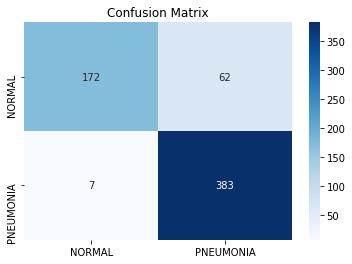

In [26]:
# calling the confusion matrix    
conf_matrix(cm)

print(classification_report(test_labels, np.round(preds)))